In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Define paths for train, validation, and test directories
train_dir = '/home/jovyan/Data Mining and Machine Learning/Dataset_New/train'
val_dir = '/home/jovyan/Data Mining and Machine Learning/Dataset_New/val'
test_dir = '/home/jovyan/Data Mining and Machine Learning/Dataset_New/test'

# Define Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to VGG16 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG16 normalization values
])

# Load datasets with the transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize VGG16 model and modify the classifier for two classes (live and spoof)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # Replace last layer for binary classification
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [4]:

# Training function
def train(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader)
    val_accuracy = evaluate(model, val_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/10], Loss: 0.6695, Validation Accuracy: 78.32%
Epoch [2/10], Loss: 0.3568, Validation Accuracy: 90.01%
Epoch [3/10], Loss: 0.2868, Validation Accuracy: 88.30%
Epoch [4/10], Loss: 0.5628, Validation Accuracy: 78.32%
Epoch [5/10], Loss: 0.5381, Validation Accuracy: 78.32%
Epoch [6/10], Loss: 0.5306, Validation Accuracy: 78.32%
Epoch [7/10], Loss: 0.5279, Validation Accuracy: 78.32%
Epoch [8/10], Loss: 0.5263, Validation Accuracy: 78.32%
Epoch [9/10], Loss: 0.5277, Validation Accuracy: 78.32%
Epoch [10/10], Loss: 0.5273, Validation Accuracy: 78.32%


In [5]:

# Evaluate on the test set after training
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'vgg16_liveness_detection.pth')


Test Accuracy: 78.01%


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


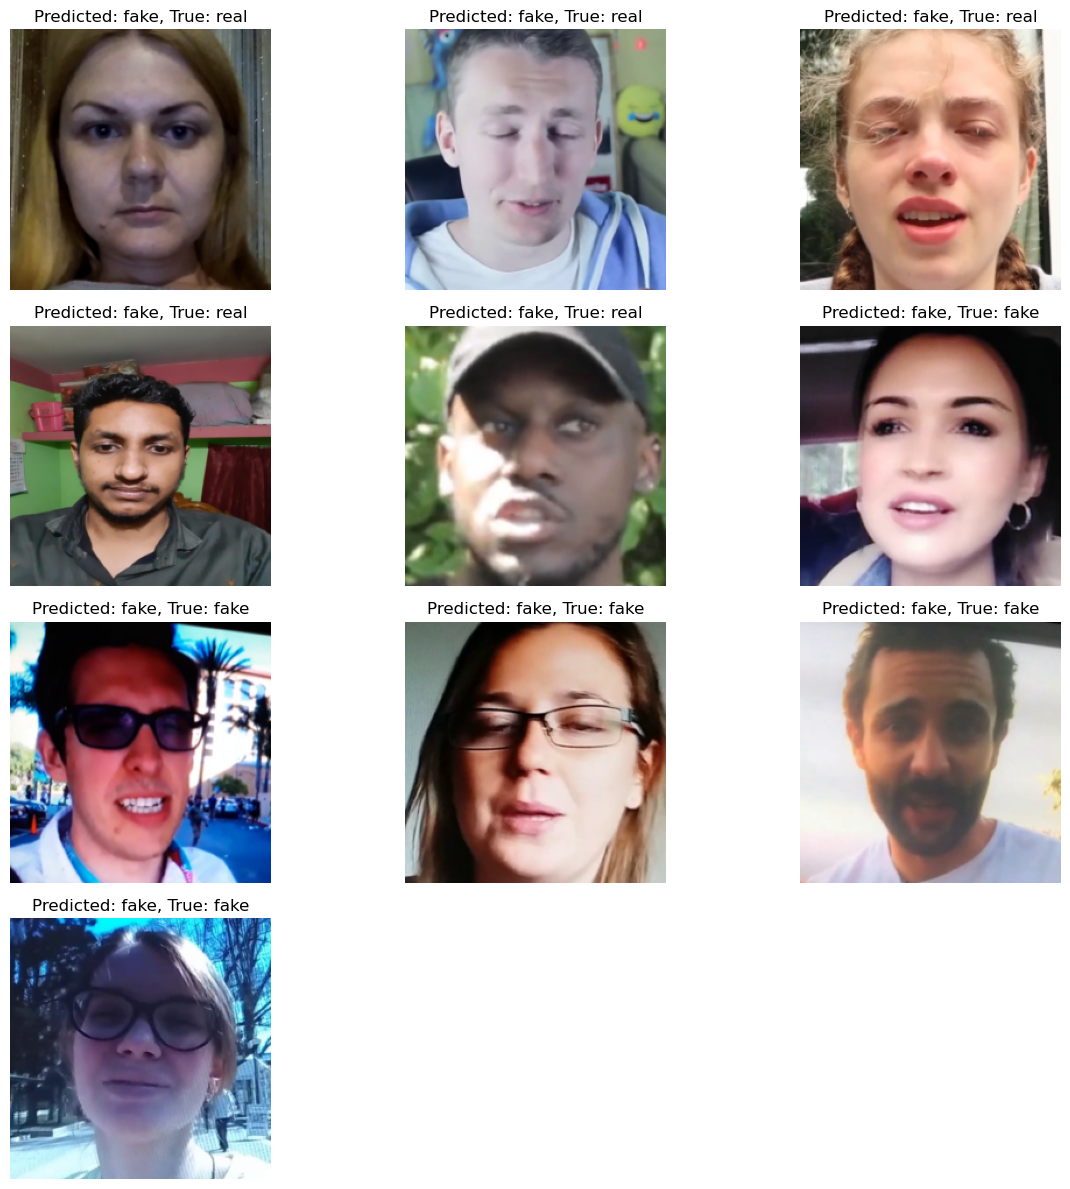

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from torchvision import models  # Import models from torchvision

# Define the model path
model_path = '/home/jovyan/Data Mining and Machine Learning/vgg16_liveness_detection.pth'

# Load the pretrained model and set it to evaluation mode
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.vgg16(pretrained=False)  # Create the VGG16 model structure
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)  # Adjust for binary classification
model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
model = model.to(device)
model.eval()

# Class labels
class_names = ['fake', 'real']  # Assuming the class names are ['fake', 'real']

# Function to display an image with its predicted and true label
def display_image_with_prediction(image, predicted_label, true_label):
    # Unnormalize the image
    img = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    
    # Plot the image
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]}, True: {class_names[true_label]}")
    plt.axis('off')

# Collect predictions, actual labels, and images for the entire test set
all_preds = []
all_labels = []
all_images = []

# Evaluate on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Perform inference
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions, actual labels, and images
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())  # Store images for random selection



# Select a balanced random sample of images from each class for visualization
real_indices = [i for i in range(len(all_labels)) if all_labels[i] == 1]
fake_indices = [i for i in range(len(all_labels)) if all_labels[i] == 0]

# Ensure at least 5 images exist for each class before sampling
real_sample = random.sample(real_indices, min(5, len(real_indices)))
fake_sample = random.sample(fake_indices, min(5, len(fake_indices)))

sample_indices = real_sample + fake_sample

# Display selected images with predictions
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 3, i + 1)
    display_image_with_prediction(all_images[idx], all_preds[idx], all_labels[idx])
plt.tight_layout()
plt.show()



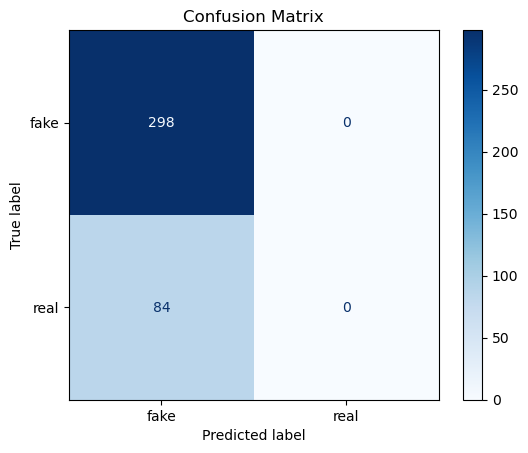

In [7]:
# Generate and display the confusion matrix for the entire test set
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [10]:
import time
from sklearn.metrics import accuracy_score, precision_score

# Preprocess a single image (assuming test_loader is already defined)
def preprocess_single_image(image_path):
    from PIL import Image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to VGG16 input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Measure inference time for a single image
def measure_inference_time(image_path):
    image = preprocess_single_image(image_path)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    end_time = time.time()
    inference_time = end_time - start_time
    return predicted.item(), inference_time

# Example Usage

# Single image inference
image_path = "/home/jovyan/Data Mining and Machine Learning/Dataset/test/fake/1_3.avi_125_fake.jpg"  # Update with the actual image path
predicted_label, inference_time = measure_inference_time(image_path)
print(f"Predicted Label: {class_names[predicted_label]}, Inference Time: {inference_time:.4f} seconds")

# Model evaluation on test dataset
accuracy, precision = evaluate_model(test_loader)
print(f"Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%")


Predicted Label: fake, Inference Time: 0.0007 seconds
Accuracy: 86.73%, Precision: 0.00%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
